# Analise sobre o potencial usuario do nosso aplicativo

#### Impotações

In [19]:
#importanções nescessarias para a base
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, precision_recall_fscore_support
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler



### Tratando a base

In [20]:
#lendo o df_ATHLETA
df_ATHLETA = pd.read_csv('ATHLETA.csv')

In [21]:
#deletando colunas que não usariamos na analise
colunas_deletar=['Carimbo de data/hora','Nome Completo']
df_ATHLETA=df_ATHLETA.drop(columns=colunas_deletar)

#### Transformando em array e separando esportes em colunas binarias

In [22]:
mlb1 = MultiLabelBinarizer()
y = mlb1.fit_transform(df_ATHLETA['Quais esportes você pratica atualmente?'])  # Formato correto

mlb2 = MultiLabelBinarizer()
X_sports = mlb2.fit_transform(df_ATHLETA['Quais esportes você tem interesse em experimentar?'])  # Esse será parte das features (X)
X_sports = pd.DataFrame(X_sports, columns=[f"experimenta_{col}" for col in mlb2.classes_])


In [23]:
X = pd.concat([df_ATHLETA.drop(columns=['Quais esportes você pratica atualmente?', 'Quais esportes você tem interesse em experimentar?']), X_sports], axis=1)

In [24]:
#criando o objeto do label encoder
label_encoder = LabelEncoder()
 
#criando o processador
# a gente usa o dicionario de cada coluna, pra quando serializar poder levar o dicionario junto
preprocessador = ColumnTransformer(transformers=[
    ('categoricas',OrdinalEncoder(),make_column_selector(dtype_include=['object','bool']))
],
remainder='passthrough',
verbose_feature_names_out = False)
 

X_pre= preprocessador.fit_transform(X)
display(X_pre)
display(y)

array([[ 6.,  0., 12., ...,  0.,  0.,  0.],
       [ 6.,  1., 18., ...,  0.,  0.,  0.],
       [ 6.,  1., 18., ...,  0.,  0.,  0.],
       ...,
       [ 6.,  1., 12., ...,  1.,  1.,  0.],
       [ 6.,  1.,  7., ...,  0.,  0.,  0.],
       [ 6.,  2., 12., ...,  1.,  1.,  0.]])

array([[1, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 0]])

### Treinando com diferentes tipos de modelo

In [25]:
from sklearn.multioutput import MultiOutputClassifier
from catboost import CatBoostClassifier

# Treinando o modelo CatBoost com MultiOutputClassifier
model = MultiOutputClassifier(CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0))
model.fit(X_pre, y)

# Pegando a importância das features para cada classificador
importances = []

for i in range(y.shape[1]):
    # Obtendo a importância das features para cada saída
    importances.append(model.estimators_[i].get_feature_importance(prettified=True))

# Mapeando os índices de volta para os nomes das colunas e organizando os resultados
for i, importance in enumerate(importances):
    feature_names = np.array(X.columns)
    importance['Feature Name'] = importance['Feature Id'].apply(lambda x: feature_names[int(x)])
    importance = importance.sort_values(by='Importances', ascending=False)
    
    # Definindo um percentual das features mais importantes
    threshold_percentage = 0.25  # Mantendo apenas as features com 25% de importância
    threshold_value = importance['Importances'].quantile(1 - threshold_percentage)
    
    # Filtrando as features importantes
    important_features = importance[importance['Importances'] >= threshold_value]['Feature Name'].tolist()
    
    # Novo DataFrame para as features com mais importância
    X_filtered = X[important_features]
    
    # Exibindo as features mais importantes para cada saída
    print(f"Features importantes para a classe {mlb1.classes_[i]}:")
    print(X_filtered.head())  # Mostrando as primeiras linhas do novo DataFrame filtrado


Features importantes para a classe  :
  Com que frequência você pratica esportes?  \
0                              Semanalmente   
1                               Diariamente   
2                               Diariamente   
3                              Semanalmente   
4                              Semanalmente   

  Qual é o seu nível de envolvimento com esportes não tão conhecidos?  \
0                                              Médio                    
1                                               Alto                    
2                                               Alto                    
3                                              Baixo                    
4                                              Baixo                    

  Com que frequência você usa aplicativos relacionados a esportes?  \
0                                       Semanalmente                 
1                                        Diariamente                 
2                             

In [26]:
X_filtered =preprocessador.fit_transform(X)

##### Aplicando com PCA ( X_PCA )

In [27]:
#escalonamento
scaler = StandardScaler()
X_escalonado= pd.DataFrame(scaler.fit_transform(X_filtered))

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X_escalonado)

##### Catboost

In [29]:
#seprando treino e teste 
X_treino, X_teste, y_treino, y_teste = train_test_split(X_pre, y, test_size=0.25, random_state=42)
X_treino_PCA,X_teste_PCA,y_treino_PCA,y_teste_PCA = train_test_split(X_PCA,y,test_size=0.25)


#### MultiOutputClassifier

##### Treinando normal

In [30]:
# Criação do classificador multi-output
multiOutputClassifier = MultiOutputClassifier(RandomForestClassifier())

# Treinamento do modelo
multiOutputClassifier.fit(X_treino, y_treino)

# Fazendo previsões
previsoes = multiOutputClassifier.predict(X_teste)  # Chame o método na instância treinada

# Avaliando o modelo
reporte = classification_report(y_teste, previsoes)
print(reporte)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        32
           1       0.55      0.77      0.64        22
           2       0.50      0.50      0.50        14
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00         1
           6       0.50      0.36      0.42        11
           7       0.86      0.43      0.57        14
           8       0.78      0.86      0.82        21
           9       0.00      0.00      0.00        11
          10       0.80      1.00      0.89        32
          11       0.58      0.78      0.67        18
          12       0.57      0.91      0.70        22
          13       0.82      0.97      0.89        32
          14       0.98      1.00      0.99        43
          15       0.00      0.00      0.00         1
          16       0.54      0.37      0.44        19
          17       0.79    

C:\Users\stephanysilva-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Treinando com PCA

In [31]:
# Criação do classificador multi-output
multiOutputClassifier = MultiOutputClassifier(RandomForestClassifier())

# Treinamento do modelo
multiOutputClassifier.fit(X_treino_PCA, y_treino_PCA)

# Fazendo previsões
previsoes = multiOutputClassifier.predict(X_teste_PCA)  # Chame o método na instância treinada

# Avaliando o modelo
reporte = classification_report(y_teste_PCA, previsoes)
print(reporte)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        35
           1       0.44      0.57      0.50        21
           2       0.45      0.48      0.47        21
           3       0.00      0.00      0.00         6
           4       0.45      0.56      0.50        16
           5       0.00      0.00      0.00         1
           6       0.36      0.33      0.35        12
           7       0.12      0.06      0.08        16
           8       0.60      0.56      0.58        16
           9       0.00      0.00      0.00         7
          10       0.80      0.80      0.80        35
          11       0.35      0.47      0.40        15
          12       0.68      0.85      0.75        27
          13       0.79      0.77      0.78        35
          14       1.00      1.00      1.00        44
          15       0.00      0.00      0.00         1
          16       0.52      0.62      0.57        21
          17       0.83    

C:\Users\stephanysilva-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### KNN

##### Treinanod normal

In [32]:
from sklearn.model_selection import GridSearchCV

# MultiOutputClassifier para KNN
multiOutputClassifier = MultiOutputClassifier(KNeighborsClassifier())

# Definindo o grid de parâmetros: neste caso, vamos testar diferentes valores para o n_neighbors
param_grid = {
    'estimator__n_neighbors': range(1, 70)  # Testando de 1 até 69 vizinhos
}

# Configurando o GridSearchCV
grid_search = GridSearchCV(multiOutputClassifier, param_grid, cv=3, scoring='accuracy', verbose=1)
# Treinando com o grid search
grid_search.fit(X_treino, y_treino)

best_model = grid_search.best_estimator_


Fitting 3 folds for each of 69 candidates, totalling 207 fits


In [33]:
# Fazer previsões com o melhor modelo encontrado no GridSearchCV
previsoes = best_model.predict(X_teste)

# Calcular a acurácia média para todas as saídas (multi-output)
accuracy = np.mean([accuracy_score(y_teste[:, i], previsoes[:, i]) for i in range(y_teste.shape[1])])

print(f'Acurácia: {accuracy}')

Acurácia: 0.662878787878788


##### Treinando com pca

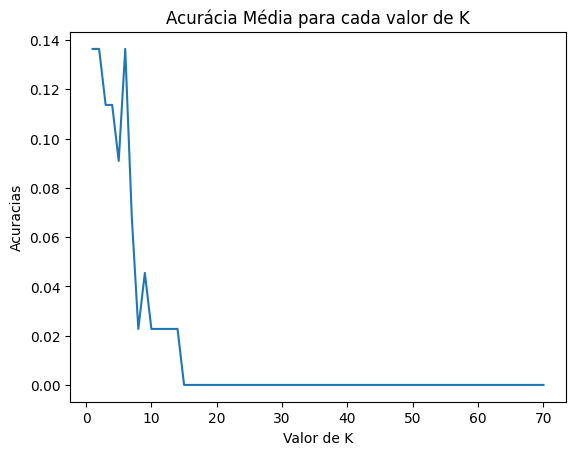

In [34]:
#seprando treino e teste 
melhor=0
k=0
acurcias=[]
ks=[]
for cada_K in range(70):
	#criando o classificador
	classificador_knn = KNeighborsClassifier(n_neighbors=cada_K+1)
	classificador_knn.fit(X_treino_PCA,y_treino_PCA)

	previsoes= classificador_knn.predict(X_teste_PCA)
	acuracia = accuracy_score(y_teste_PCA, previsoes)
	acurcias.append(acuracia)
	ks.append(cada_K+1)

	if acuracia>melhor:
		melhor=acuracia
		k=cada_K+1

 
plt.plot(ks, acurcias)
plt.xlabel('Valor de K')
plt.ylabel('Acuracias')
plt.title('Acurácia Média para cada valor de K')
plt.show()

In [35]:
# Configurando o GridSearchCV
grid = GridSearchCV(estimator=classificador_knn,param_grid = param_grid, cv=5, scoring='accuracy')
grid.fit(X_treino_PCA, y_treino_PCA)

# Usando os melhores parâmetros encontrados pelo GridSearchCV
classificador_knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])

# Treine o classificador com os melhores parâmetros
classificador_knn.fit(X_treino_PCA, y_treino_PCA)

# Faça previsões
previsoes = classificador_knn.predict(X_teste_PCA)

# Mostre o relatório
reporte = classification_report(y_teste_PCA, previsoes)
print("Reporte de tudo: \n", reporte)

ValueError: Invalid parameter 'estimator' for estimator KNeighborsClassifier(n_neighbors=70). Valid parameters are: ['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'].

-- notas

knn com pca

ele ta chutando muito falso negativo no sim

#### Arvore de decisão

In [ ]:
# Defina o dicionário de parâmetros
parametros = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

# Crie o classificador e o objeto GridSearchCV


##### Treinando normal

In [ ]:

# Definindo o classificador de Árvore de Decisão
classificador_tree = tree.DecisionTreeClassifier(random_state=0)

# Definindo os parâmetros para o GridSearchCV
parametros = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurando o GridSearchCV
grid = GridSearchCV(estimator=classificador_tree, param_grid=parametros, cv=5, scoring='accuracy')
grid.fit(X_treino, y_treino)

# Usando o melhor classificador encontrado pelo GridSearchCV
classificador_tree = grid.best_estimator_

# Faça previsões
previsoes = classificador_tree.predict(X_teste)

# Mostre o relatório
reporte = classification_report(y_teste, previsoes)
print("Reporte de tudo: \n", reporte)



Reporte de tudo: 
               precision    recall  f1-score   support

           0       0.75      0.84      0.79        32
           1       0.56      0.68      0.61        22
           2       0.35      0.57      0.43        14
           3       0.20      0.33      0.25         6
           4       0.23      0.20      0.21        15
           5       0.00      0.00      0.00         1
           6       0.11      0.09      0.10        11
           7       0.21      0.21      0.21        14
           8       0.76      0.76      0.76        21
           9       0.44      0.36      0.40        11
          10       0.76      0.88      0.81        32
          11       0.50      0.56      0.53        18
          12       0.44      0.50      0.47        22
          13       0.74      0.81      0.78        32
          14       0.98      0.95      0.96        43
          15       0.00      0.00      0.00         1
          16       0.41      0.37      0.39        19
        

C:\Users\stephanysilva-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##### Treinando normal com pca

In [ ]:

# Definindo o classificador de Árvore de Decisão
classificador_tree = tree.DecisionTreeClassifier(random_state=0)

# Definindo os parâmetros para o GridSearchCV
parametros = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Configurando o GridSearchCV
grid = GridSearchCV(estimator=classificador_tree, param_grid=parametros, cv=5, scoring='accuracy')
grid.fit(X_treino_PCA, y_treino_PCA)

# Usando o melhor classificador encontrado pelo GridSearchCV
classificador_tree = grid.best_estimator_

# Faça previsões
previsoes = classificador_tree.predict(X_teste_PCA)

# Mostre o relatório
reporte = classification_report(y_teste_PCA, previsoes)
print("Reporte de tudo: \n", reporte)

Reporte de tudo: 
               precision    recall  f1-score   support

           0       0.68      0.90      0.78        29
           1       0.49      0.89      0.63        19
           2       0.56      0.56      0.56        18
           3       0.25      0.17      0.20         6
           4       0.18      0.23      0.20        13
           5       0.00      0.00      0.00         0
           6       0.13      0.25      0.17         8
           7       0.46      0.43      0.44        14
           8       0.43      0.64      0.51        14
           9       0.20      0.12      0.15         8
          10       0.68      0.90      0.78        29
          11       0.36      0.67      0.47        15
          12       0.50      0.59      0.54        22
          13       0.68      0.90      0.78        29
          14       1.00      0.98      0.99        44
          15       0.00      0.00      0.00         0
          16       0.50      0.39      0.44        23
        

C:\Users\stephanysilva-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\stephanysilva-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\stephanysilva-ieg\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 